In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torch.utils.data as data
from torch.optim import SGD
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random
import torch.utils.data as torchdata
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
%matplotlib inline
import pickle

In [2]:
import tent

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
def get_dataset(path='/database', dataset_name='caltech-256-common'):
    # No holdout testing data. train and test data are the same, but different transformation
    data_transforms = {
        'train': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

    tr_dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms['train'])
    te_dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms['test'])

    return tr_dataset, te_dataset

In [5]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [9]:
def split_dataset(train_dataset, test_dataset, valid_size=0.02, batch_size=128, train_size = 128, seed_worker=None, deterministic=False):
    '''
    This function splits dataset into train, val, and test sets, and return train, val, test dataloaders.
    Val and Test loaders are the same

    '''
    g = torch.Generator()
    if deterministic:
        print("Controled order, setting manual seed")
        g.manual_seed(0)
        random.seed(0)
    # what does the len function gives?
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    random.shuffle(indices)
    train_idx, valid_idx = indices[split:split+train_size], indices[:split]
    
    train_sampler = SubsetRandomSampler(train_idx, g)
    valid_sampler = SubsetRandomSampler(valid_idx, g)

    train_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=48, worker_init_fn=seed_worker, pin_memory=True, drop_last=False, sampler = train_sampler)
    test_loader = torchdata.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=48, worker_init_fn=seed_worker, pin_memory=True, drop_last=False, sampler = valid_sampler)
    dataloaders = {'train': train_loader,
                   'val': test_loader,
                   'test': test_loader}
    dataset_sizes ={'train': train_size, #int(np.floor((1-valid_size) * num_train)),
                    'val': int(np.floor(valid_size * num_train)),
                    'test': int(np.floor(valid_size * num_train))}
    return dataloaders, dataset_sizes, valid_idx, g

In [10]:
imagebase = '/local/rcs/ll3504/datasets/'

In [11]:

corruption = ['fog', 'snow', 'spatter', 'gaussian_blur', 'gaussian_noise', 'brightness']
weather = ['fog', 'snow', 'spatter', 'frost']
digital = ['gaussian_noise', 'gaussian_blur', 'brightness', 'defocus_blur', 'contrast'] # NO gaussian noise in the files


In [12]:
def get_imagenetc(imagebase, batch_size=128, sample_size = 128, corruption=corruption, seed_worker=None, deterministic=False):
    '''
    Returns:
        ref_dataloaders:          ImageNet original validation data, as a reference
        ref_dataset_sizes:        1000, not the sizes of the real dataset in the ref_loader, probs used downstream
        corrupted_dataloaders:    A list of corrupted dataloaders, each element in a list represetns the data loaders
                                  for one corruption type. Each element contains ['train']['val']['test'] loaders
        corrupted_dataset_sizes:  A list of dictionaries of the sizes of each loaders for each corruption
        corruption:               A list of corruption names, in the same order of the corrupted_dataloaders
    '''
    corrupted_dataloaders = {}
    
    # for every type of corruption, go to the specified severity folder
    for corr in corruption:
        dataloader_all_sev = []

        for severity in range(1,6):
            
            dataset_name = 'imagenetc/' + corr + '/' + str(severity)
            # Get dataset from folder
            corr_trian_images, corr_test_images = get_dataset(imagebase, dataset_name)

            # Get corruption-specific train, val, test loader
                # train: training data, non-overlap with val/test
                # val: non-overlap with train, same as test
                # test: non-overlap with train, same as test

            corr_dataloaders, _, val_ind, g = split_dataset(corr_trian_images, corr_test_images, valid_size=0.02, 
                                                                batch_size=batch_size, train_size=sample_size, 
                                                                seed_worker=seed_worker, deterministic=deterministic)
            dataloader_all_sev.append(corr_dataloaders)
            corrupted_dataloaders[corr] = dataloader_all_sev
            
    # get 1000 clean images for validation reference
    imagenet_val = datasets.ImageNet(imagebase+'imagenetc/', split='val', transform=transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
                                   target_transform=None)#, download=False)
    if deterministic:
        valid_sampler = SubsetRandomSampler(val_ind, g)

        clean_val_loader = torch.utils.data.DataLoader(imagenet_val,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=48,
                                                  worker_init_fn=seed_worker, 
                                                  sampler = valid_sampler)
    else:
        random_indices = random.sample(range(0, len(imagenet_val)), int(len(imagenet_val)*0.02))
        imagenet_val_subset = data.Subset(imagenet_val, random_indices)
        clean_val_loader = torch.utils.data.DataLoader(imagenet_val_subset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=48)

    corrupted_dataloaders['clean'] = clean_val_loader

        
        
#     return ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption
    return clean_val_loader, corrupted_dataloaders




# Get the data, shuffled

In [13]:
clean_loader, imc_loaders = get_imagenetc(imagebase, batch_size=64, sample_size = 49000, corruption=(weather+digital))
clean_loader, imc_loaders

(<torch.utils.data.dataloader.DataLoader at 0x7f55e79d9280>,
 {'fog': [{'train': <torch.utils.data.dataloader.DataLoader at 0x7f56411e6c40>,
    'val': <torch.utils.data.dataloader.DataLoader at 0x7f585405efd0>,
    'test': <torch.utils.data.dataloader.DataLoader at 0x7f585405efd0>},
   {'train': <torch.utils.data.dataloader.DataLoader at 0x7f58541cad00>,
    'val': <torch.utils.data.dataloader.DataLoader at 0x7f58541ca730>,
    'test': <torch.utils.data.dataloader.DataLoader at 0x7f58541ca730>},
   {'train': <torch.utils.data.dataloader.DataLoader at 0x7f5641206130>,
    'val': <torch.utils.data.dataloader.DataLoader at 0x7f5641206d60>,
    'test': <torch.utils.data.dataloader.DataLoader at 0x7f5641206d60>},
   {'train': <torch.utils.data.dataloader.DataLoader at 0x7f56412061c0>,
    'val': <torch.utils.data.dataloader.DataLoader at 0x7f5641206340>,
    'test': <torch.utils.data.dataloader.DataLoader at 0x7f5641206340>},
   {'train': <torch.utils.data.dataloader.DataLoader at 0x7f5641

In [14]:
def online_evaluate(corrupt_loaders, corrutpion, severity, lr):
    start = time.time()
    resnet50 = models.resnet50(pretrained=True)
    resnet50 = tent.configure_model(resnet50)
    params, param_names = tent.collect_params(resnet50)
    optimizer = SGD(params, lr=lr)
    tented_resnet50 = tent.Tent(resnet50, optimizer).to(device)

    num_correct, num_samples = 0., 0.
    
    trainloader = corrupt_loaders[corrutpion][severity-1]['train']

    for images, targets in trainloader:
        logits = tented_resnet50(images.to(device))
        predictions = logits.argmax(dim=1)
        num_correct += (predictions.detach().cpu() == targets).float().sum()
        num_samples += len(targets)

    adapt_time = time.time() - start
    accuracy = num_correct / num_samples
    print(f"Acc =: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * accuracy: .2f} %), \
            Error =: {100 * (1 - accuracy): .2f} %")
    print(f"Adaptation time for one epoch on {num_samples} images takes {adapt_time}s")
    return tented_resnet50, accuracy, adapt_time


In [15]:
def offline_validate(model, corrupt_loaders, corruption, severity, baseline=False, clean_data=False, bn_adapt=False):
    if baseline:
        if not bn_adapt:
            model.eval()
        else:
            model.train() # TODO: this is a very sloppy way of doing it, change it
    else:
        if not bn_adapt: # If we don't adapt the BN statistics at validation time, set to eval mode.
            model.model.eval() 
        model.offline_validation()
        
    if clean_data:
        valloader = corrupt_loaders['clean']
    else:
        valloader = corrupt_loaders[corruption][severity-1]['val']
    
    num_correct, num_samples = 0., 0.

#     with model.no_grad():
    for images, targets in valloader:
        logits = model(images.to(device))
        predictions = logits.argmax(dim=1)
        num_correct += (predictions.detach().cpu() == targets).float().sum()
        num_samples += len(targets)

    accuracy = num_correct / num_samples
    print(f"Validation Acc =: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * accuracy: .2f} %), \
            Validation Error =: {100 * (1 - accuracy): .2f} %")
    
    return accuracy

## Checking if the shuffled dataloader is deterministic or not

In [16]:
snow_loader = imc_loaders['snow'][0]['val']
len(snow_loader)

16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


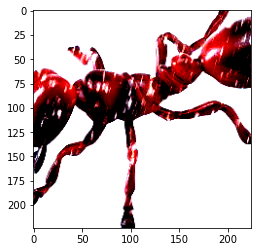

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


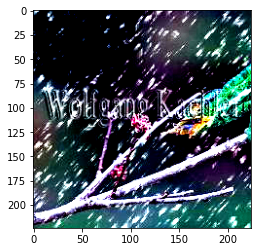

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


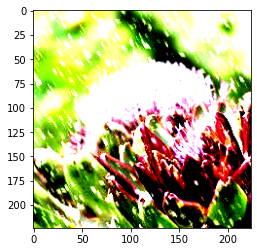

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


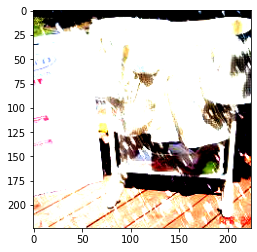

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


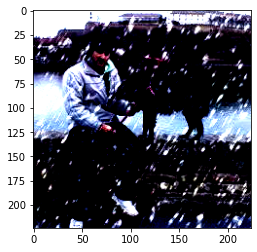

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


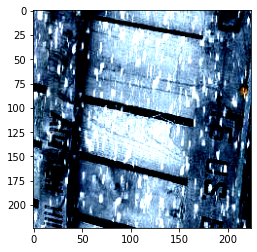

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


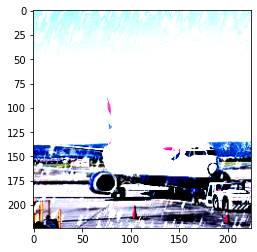

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


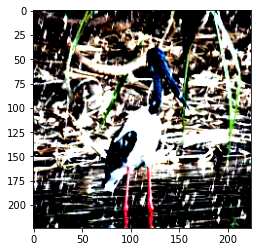

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


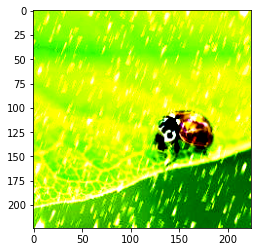

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


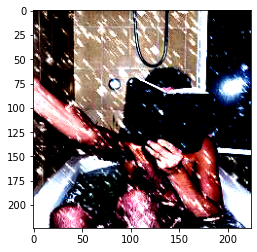

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


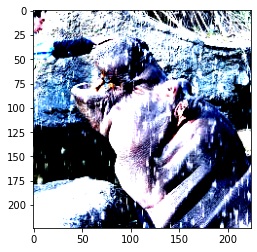

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


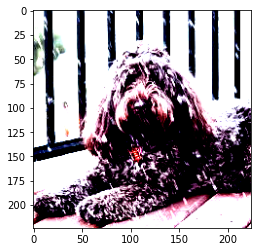

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


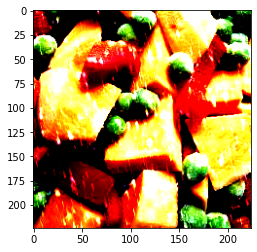

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


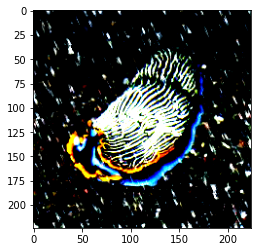

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


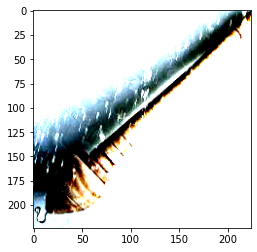

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


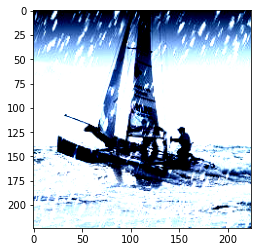

In [17]:
for images, targets in snow_loader:
    plt.imshow((images[0]).permute(1, 2, 0))
    plt.show()

In [18]:
fog_loader = imc_loaders['fog'][0]['val']
len(fog_loader)

16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


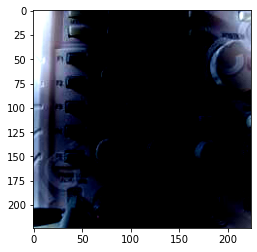

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


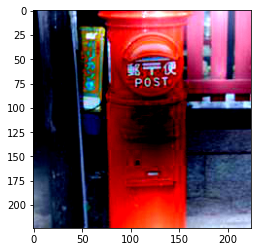

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


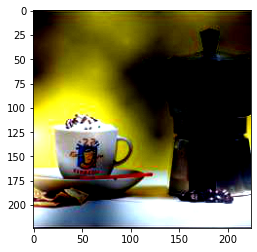

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


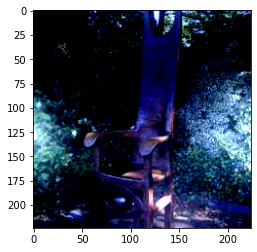

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


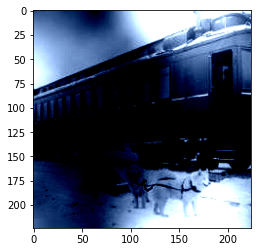

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


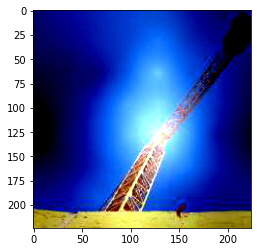

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


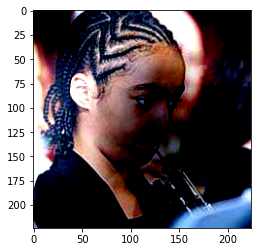

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


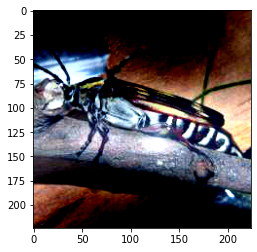

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


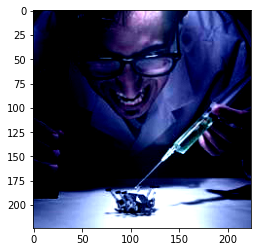

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


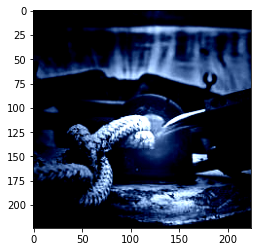

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


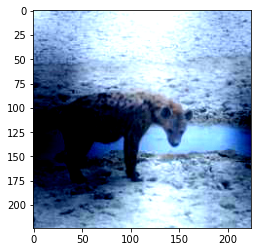

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


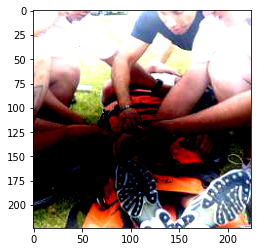

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


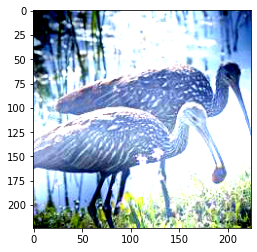

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


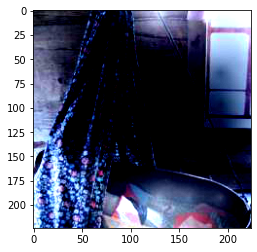

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


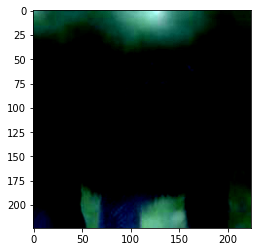

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


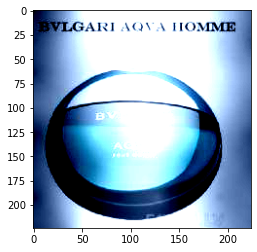

In [19]:
for images, targets in fog_loader:
    plt.imshow((images[0]).permute(1, 2, 0))
    plt.show()

In [20]:
len(clean_loader)

16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


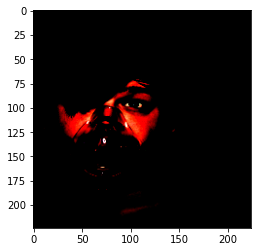

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


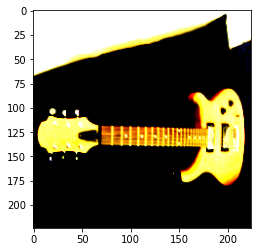

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


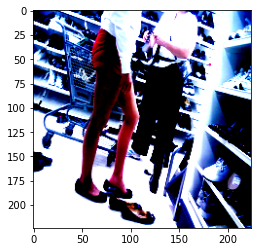

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


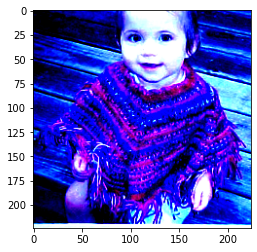

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


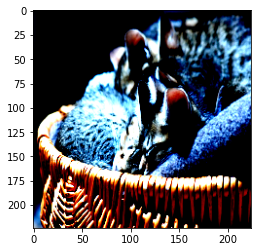

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


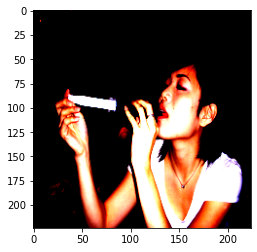

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


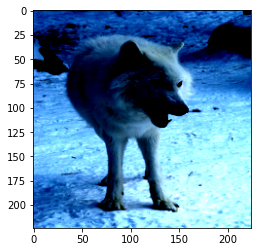

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


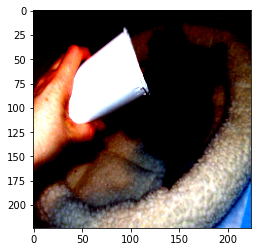

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


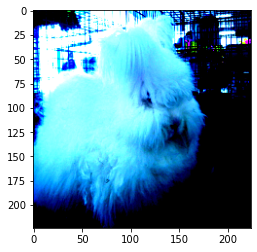

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


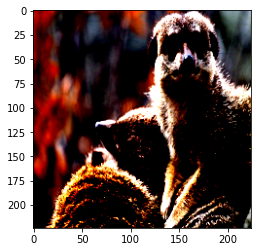

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


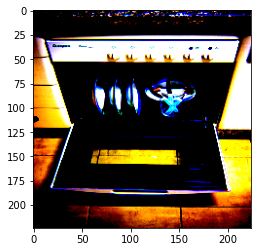

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


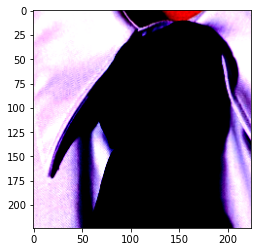

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


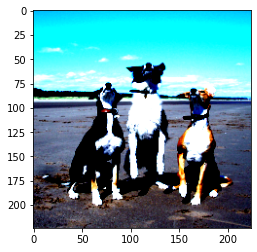

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


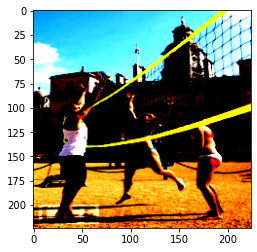

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


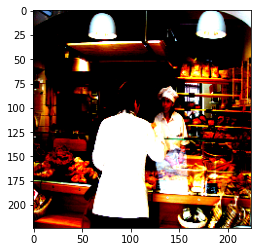

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


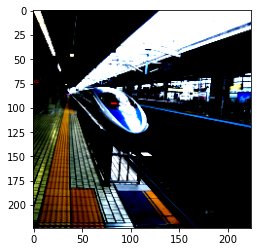

In [21]:
for images, targets in clean_loader:
    plt.imshow((images[0]).permute(1, 2, 0))
    plt.show()

# 7x7 Table - adapt + cross validate

In [22]:
weather_us = ['fog', 'snow', 'spatter']
digital_us = ['gaussian_noise', 'gaussian_blur', 'brightness']
weather_us + digital_us

['fog', 'snow', 'spatter', 'gaussian_noise', 'gaussian_blur', 'brightness']

In [23]:
cross_valid_acc = {}
lr = 0.00025

for corr in weather_us + digital_us:
    online_acc_sum = 0
    cross_valid_acc[corr] = {}
    
    for severity in [3]:
        print(f"Corruption: {corr}, Severity: {severity}")

        # online adaptation:
        adapted_model, accuracy, _ = online_evaluate(imc_loaders, corr, severity, lr)
        online_acc_sum += accuracy
        
        # offline validation on clean set
        print(f"cross-validating on clean data")
        val_acc = offline_validate(adapted_model, imc_loaders, corruption=None, severity=None, clean_data=True)
        cross_valid_acc[corr]['clean'] = val_acc        
        
        # offline validation:
        for val_corr in weather_us + digital_us:
            print(f"cross-validating on corruption = {val_corr}")
            val_acc = offline_validate(adapted_model, imc_loaders, val_corr, severity)
            cross_valid_acc[corr][val_corr] = val_acc

#     print(f"Averag online accuracy for {corr}: {100 * (online_acc_sum / 5): .2f} %, \
#             Averag online error for {corr}: {100 * (1 - online_acc_sum / 5): .2f} % ")
#     print()
#     print(f"Averag validation accuracy for {corr}: {100 * (validate_acc_sum / 5): .2f} %, \
#             Averag validation error for {corr}: {100 * (1 - validate_acc_sum / 5): .2f} % ")
    print("======================================================================================")

Corruption: fog, Severity: 3
Acc =: 30768./49000. ( 62.79 %),             Error =:  37.21 %
Adaptation time for one epoch on 49000.0 images takes 131.87433695793152s
cross-validating on clean data
Validation Acc =:  546./1000. ( 54.60 %),             Validation Error =:  45.40 %
cross-validating on corruption = fog
Validation Acc =:  682./1000. ( 68.20 %),             Validation Error =:  31.80 %
cross-validating on corruption = snow
Validation Acc =:  102./1000. ( 10.20 %),             Validation Error =:  89.80 %
cross-validating on corruption = spatter
Validation Acc =:  211./1000. ( 21.10 %),             Validation Error =:  78.90 %
cross-validating on corruption = gaussian_noise
Validation Acc =:    3./1000. ( 0.30 %),             Validation Error =:  99.70 %
cross-validating on corruption = gaussian_blur
Validation Acc =:  318./1000. ( 31.80 %),             Validation Error =:  68.20 %
cross-validating on corruption = brightness
Validation Acc =:  455./1000. ( 45.50 %),          

In [24]:
severity = 3
baseline_valid_acc = {}

vanilla = models.resnet50(pretrained=True).to(device)

print(f"cross-validating on clean data")
val_acc = offline_validate(vanilla, imc_loaders, corruption=None, severity=None, clean_data=True, baseline=True)
baseline_valid_acc['clean'] = val_acc

for val_corr in weather_us + digital_us:
    print(f"cross-validating on corruption = {val_corr}")
    val_acc = offline_validate(vanilla, imc_loaders, val_corr, severity, baseline=True)
    baseline_valid_acc[val_corr] = val_acc

cross-validating on clean data
Validation Acc =:  753./1000. ( 75.30 %),             Validation Error =:  24.70 %
cross-validating on corruption = fog
Validation Acc =:  503./1000. ( 50.30 %),             Validation Error =:  49.70 %
cross-validating on corruption = snow
Validation Acc =:  374./1000. ( 37.40 %),             Validation Error =:  62.60 %
cross-validating on corruption = spatter
Validation Acc =:  511./1000. ( 51.10 %),             Validation Error =:  48.90 %
cross-validating on corruption = gaussian_noise
Validation Acc =:  288./1000. ( 28.80 %),             Validation Error =:  71.20 %
cross-validating on corruption = gaussian_blur
Validation Acc =:  442./1000. ( 44.20 %),             Validation Error =:  55.80 %
cross-validating on corruption = brightness
Validation Acc =:  694./1000. ( 69.40 %),             Validation Error =:  30.60 %


In [ ]:
# what about running BN adapt at validation phase
cross_valid_acc = {}
lr = 0.00025

for corr in weather_us + digital_us:
    online_acc_sum = 0
    cross_valid_acc[corr] = {}
    
    for severity in [3]:
        print(f"Corruption: {corr}, Severity: {severity}")

        # online adaptation:
        adapted_model, accuracy, _ = online_evaluate(imc_loaders, corr, severity, lr)
        online_acc_sum += accuracy
        
        # offline validation on clean set
        print(f"cross-validating on clean data")
        val_acc = offline_validate(adapted_model, imc_loaders, corruption=None, severity=None, clean_data=True, bn_adapt=True)
        cross_valid_acc[corr]['clean'] = val_acc        
        
        # offline validation:
        for val_corr in weather_us + digital_us:
            print(f"cross-validating on corruption = {val_corr}")
            val_acc = offline_validate(adapted_model, imc_loaders, val_corr, severity, bn_adapt=True)
            cross_valid_acc[corr][val_corr] = val_acc

#     print(f"Averag online accuracy for {corr}: {100 * (online_acc_sum / 5): .2f} %, \
#             Averag online error for {corr}: {100 * (1 - online_acc_sum / 5): .2f} % ")
#     print()
#     print(f"Averag validation accuracy for {corr}: {100 * (validate_acc_sum / 5): .2f} %, \
#             Averag validation error for {corr}: {100 * (1 - validate_acc_sum / 5): .2f} % ")
    print("======================================================================================")

In [25]:
print(f'Batch BN adaptation at test time:')
bn_adapt_val_acc = offline_validate(vanilla, imc_loaders, corruption=None, severity=None, clean_data=True, baseline=True, bn_adapt=True)
baseline_valid_acc['BN_adapt'] = bn_adapt_val_acc

for val_corr in weather_us + digital_us:
    print(f"Batch BN adaptation on corruption = {val_corr}")
    val_acc = offline_validate(vanilla, imc_loaders, val_corr, severity, baseline=True, bn_adapt=True)
    baseline_valid_acc[val_corr] = val_acc

Batch BN adaptation at test time:
Validation Acc =:  731./1000. ( 73.10 %),             Validation Error =:  26.90 %
Batch BN adaptation on corruption = fog
Validation Acc =:  645./1000. ( 64.50 %),             Validation Error =:  35.50 %
Batch BN adaptation on corruption = snow
Validation Acc =:  470./1000. ( 47.00 %),             Validation Error =:  53.00 %
Batch BN adaptation on corruption = spatter
Validation Acc =:  616./1000. ( 61.60 %),             Validation Error =:  38.40 %
Batch BN adaptation on corruption = gaussian_noise
Validation Acc =:  449./1000. ( 44.90 %),             Validation Error =:  55.10 %
Batch BN adaptation on corruption = gaussian_blur
Validation Acc =:  403./1000. ( 40.30 %),             Validation Error =:  59.70 %
Batch BN adaptation on corruption = brightness
Validation Acc =:  717./1000. ( 71.70 %),             Validation Error =:  28.30 %


In [19]:
print(vanilla)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Same experiment, on deterministically shuffled images


In [28]:
clean_loader, imc_loaders = get_imagenetc(imagebase, batch_size=64, sample_size = 49000, corruption=(weather+digital),
                                         seed_worker=seed_worker, deterministic=True)
clean_loader, imc_loaders

Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
Controled order, setting manual seed
C

(<torch.utils.data.dataloader.DataLoader at 0x7f582c29f3d0>,
 {'fog': [{'train': <torch.utils.data.dataloader.DataLoader at 0x7f55e6fe1a30>,
    'val': <torch.utils.data.dataloader.DataLoader at 0x7f582c2be8e0>,
    'test': <torch.utils.data.dataloader.DataLoader at 0x7f582c2be8e0>},
   {'train': <torch.utils.data.dataloader.DataLoader at 0x7f582c2be7f0>,
    'val': <torch.utils.data.dataloader.DataLoader at 0x7f582c2bec70>,
    'test': <torch.utils.data.dataloader.DataLoader at 0x7f582c2bec70>},
   {'train': <torch.utils.data.dataloader.DataLoader at 0x7f582c1504f0>,
    'val': <torch.utils.data.dataloader.DataLoader at 0x7f582c316af0>,
    'test': <torch.utils.data.dataloader.DataLoader at 0x7f582c316af0>},
   {'train': <torch.utils.data.dataloader.DataLoader at 0x7f582c316a60>,
    'val': <torch.utils.data.dataloader.DataLoader at 0x7f582c316070>,
    'test': <torch.utils.data.dataloader.DataLoader at 0x7f582c316070>},
   {'train': <torch.utils.data.dataloader.DataLoader at 0x7f582c

## Checking if the shuffled dataloader is deterministic or not

In [29]:
snow_loader = imc_loaders['snow'][0]['val']
len(snow_loader)

16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


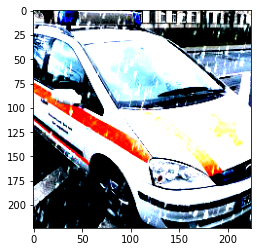

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


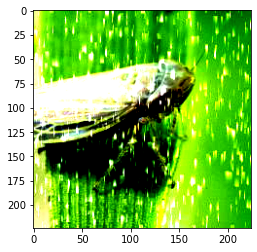

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


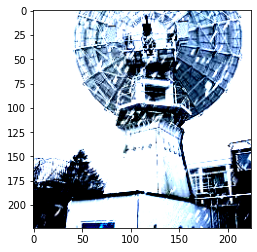

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


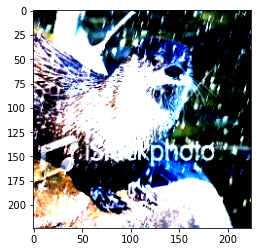

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


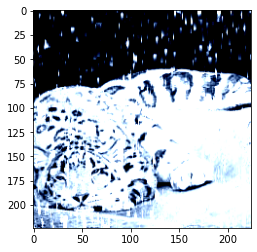

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


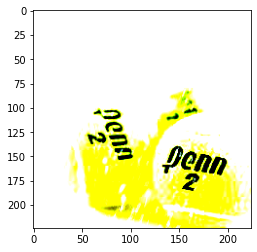

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


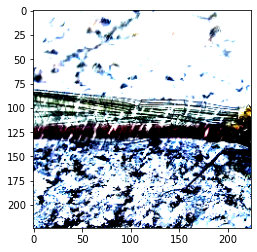

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


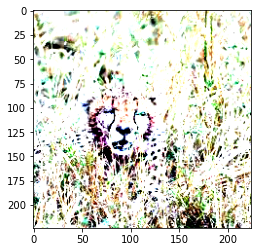

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


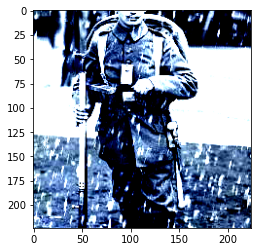

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


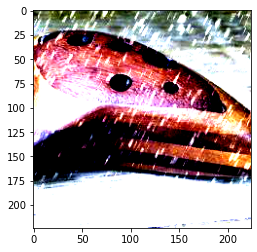

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


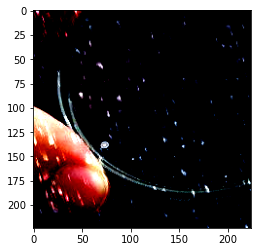

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


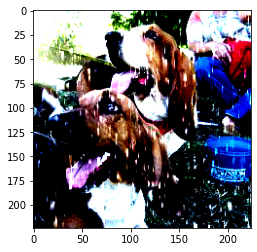

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


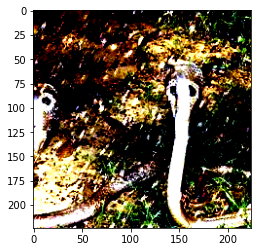

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


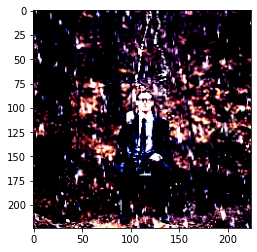

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


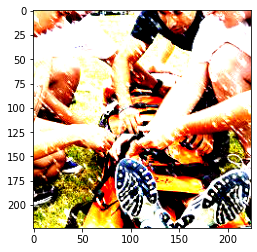

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


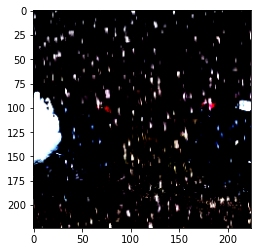

In [30]:
for images, targets in snow_loader:
    plt.imshow((images[0]).permute(1, 2, 0))
    plt.show()

In [31]:
fog_loader = imc_loaders['fog'][0]['val']
len(fog_loader)

16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


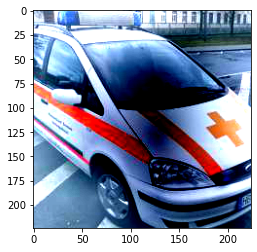

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


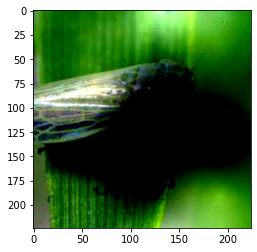

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


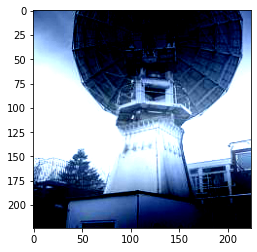

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


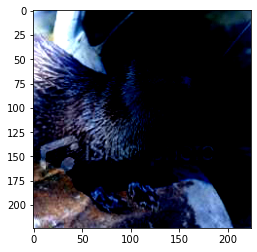

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


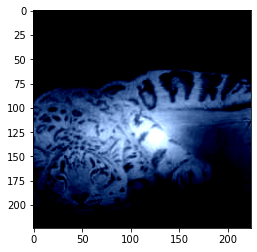

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


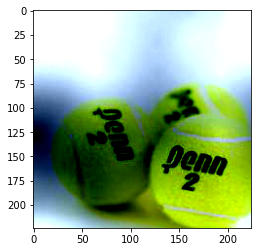

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


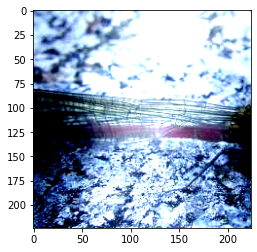

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


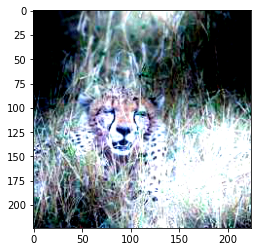

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


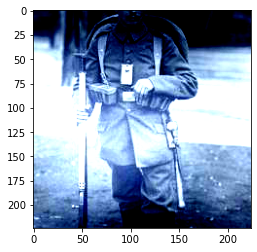

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


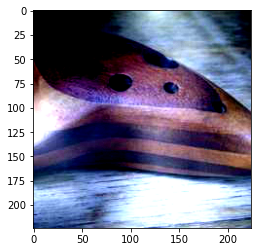

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


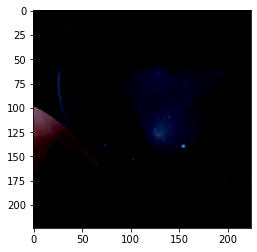

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


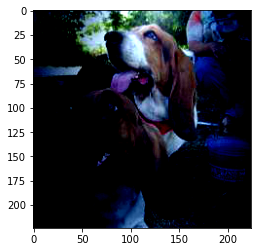

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


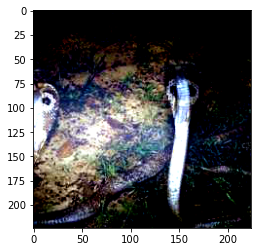

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


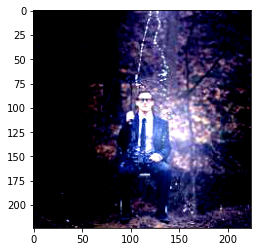

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


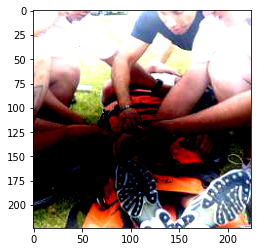

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


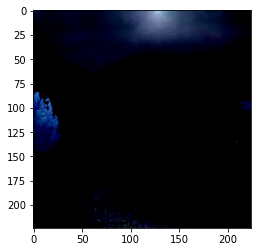

In [32]:
for images, targets in fog_loader:
    plt.imshow((images[0]).permute(1, 2, 0))
    plt.show()

In [33]:
len(clean_loader)

16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


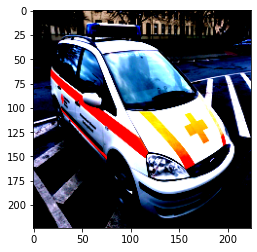

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


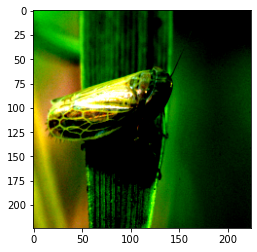

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


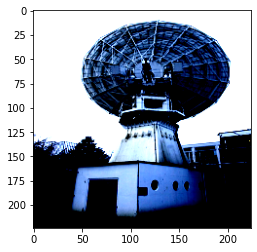

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


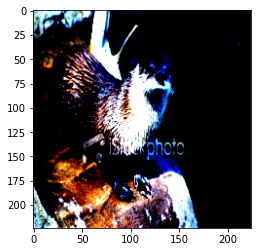

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


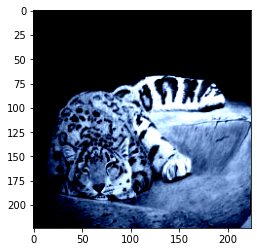

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


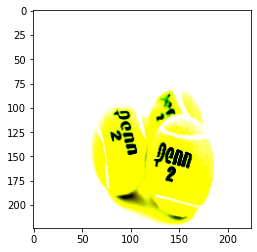

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


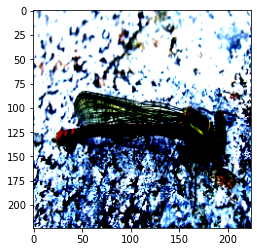

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


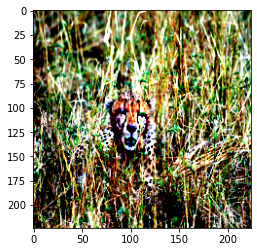

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


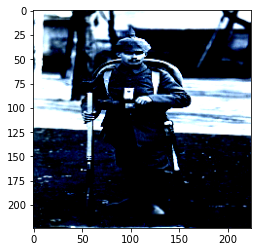

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


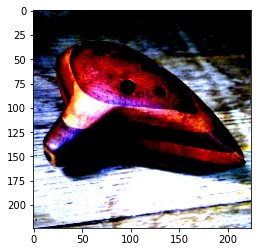

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


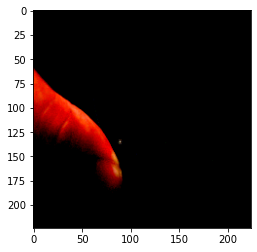

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


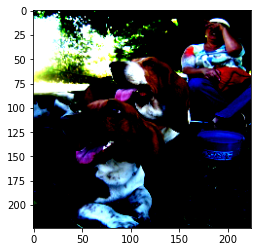

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


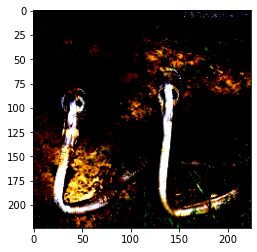

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


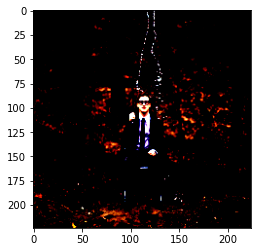

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


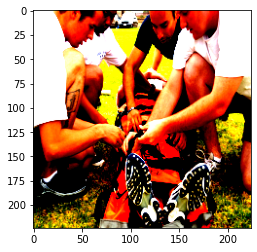

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


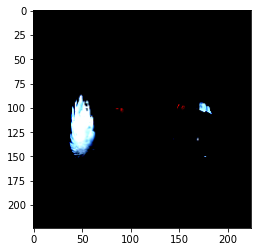

In [34]:
for images, targets in clean_loader:
    plt.imshow((images[0]).permute(1, 2, 0))
    plt.show()

# 7x7 Table - adapt + cross validate

In [35]:
weather_us = ['fog', 'snow', 'spatter']
digital_us = ['gaussian_noise', 'gaussian_blur', 'brightness']
weather_us + digital_us

['fog', 'snow', 'spatter', 'gaussian_noise', 'gaussian_blur', 'brightness']

In [36]:
cross_valid_acc = {}
lr = 0.00025

for corr in weather_us + digital_us:
    online_acc_sum = 0
    cross_valid_acc[corr] = {}
    
    for severity in [3]:
        print(f"Corruption: {corr}, Severity: {severity}")

        # online adaptation:
        adapted_model, accuracy, _ = online_evaluate(imc_loaders, corr, severity, lr)
        online_acc_sum += accuracy
        
        # offline validation on clean set
        print(f"cross-validating on clean data")
        val_acc = offline_validate(adapted_model, imc_loaders, corruption=None, severity=None, clean_data=True)
        cross_valid_acc[corr]['clean'] = val_acc        
        
        # offline validation:
        for val_corr in weather_us + digital_us:
            print(f"cross-validating on corruption = {val_corr}")
            val_acc = offline_validate(adapted_model, imc_loaders, val_corr, severity)
            cross_valid_acc[corr][val_corr] = val_acc

#     print(f"Averag online accuracy for {corr}: {100 * (online_acc_sum / 5): .2f} %, \
#             Averag online error for {corr}: {100 * (1 - online_acc_sum / 5): .2f} % ")
#     print()
#     print(f"Averag validation accuracy for {corr}: {100 * (validate_acc_sum / 5): .2f} %, \
#             Averag validation error for {corr}: {100 * (1 - validate_acc_sum / 5): .2f} % ")
    print("======================================================================================")

Corruption: fog, Severity: 3
Acc =: 30822./49000. ( 62.90 %),             Error =:  37.10 %
Adaptation time for one epoch on 49000.0 images takes 134.0244460105896s
cross-validating on clean data
Validation Acc =:  540./1000. ( 54.00 %),             Validation Error =:  46.00 %
cross-validating on corruption = fog
Validation Acc =:  648./1000. ( 64.80 %),             Validation Error =:  35.20 %
cross-validating on corruption = snow
Validation Acc =:  100./1000. ( 10.00 %),             Validation Error =:  90.00 %
cross-validating on corruption = spatter
Validation Acc =:  222./1000. ( 22.20 %),             Validation Error =:  77.80 %
cross-validating on corruption = gaussian_noise
Validation Acc =:    3./1000. ( 0.30 %),             Validation Error =:  99.70 %
cross-validating on corruption = gaussian_blur
Validation Acc =:  323./1000. ( 32.30 %),             Validation Error =:  67.70 %
cross-validating on corruption = brightness
Validation Acc =:  452./1000. ( 45.20 %),           

In [37]:
severity = 3
baseline_valid_acc = {}

vanilla = models.resnet50(pretrained=True).to(device)

print(f"cross-validating on clean data")
val_acc = offline_validate(vanilla, imc_loaders, corruption=None, severity=None, clean_data=True, baseline=True)
baseline_valid_acc['clean'] = val_acc

for val_corr in weather_us + digital_us:
    print(f"cross-validating on corruption = {val_corr}")
    val_acc = offline_validate(vanilla, imc_loaders, val_corr, severity, baseline=True)
    baseline_valid_acc[val_corr] = val_acc

cross-validating on clean data
Validation Acc =:  733./1000. ( 73.30 %),             Validation Error =:  26.70 %
cross-validating on corruption = fog
Validation Acc =:  486./1000. ( 48.60 %),             Validation Error =:  51.40 %
cross-validating on corruption = snow
Validation Acc =:  340./1000. ( 34.00 %),             Validation Error =:  66.00 %
cross-validating on corruption = spatter
Validation Acc =:  496./1000. ( 49.60 %),             Validation Error =:  50.40 %
cross-validating on corruption = gaussian_noise
Validation Acc =:  287./1000. ( 28.70 %),             Validation Error =:  71.30 %
cross-validating on corruption = gaussian_blur
Validation Acc =:  430./1000. ( 43.00 %),             Validation Error =:  57.00 %
cross-validating on corruption = brightness
Validation Acc =:  722./1000. ( 72.20 %),             Validation Error =:  27.80 %


In [39]:
# what about running BN adapt at validation phase

cross_valid_acc = {}
lr = 0.00025

for corr in weather_us + digital_us:
    online_acc_sum = 0
    cross_valid_acc[corr] = {}
    
    for severity in [3]:
        print(f"Corruption: {corr}, Severity: {severity}")

        # online adaptation:
        adapted_model, accuracy, _ = online_evaluate(imc_loaders, corr, severity, lr)
        online_acc_sum += accuracy
        
        # offline validation on clean set
        print(f"cross-validating on clean data")
        val_acc = offline_validate(adapted_model, imc_loaders, corruption=None, severity=None, clean_data=True, bn_adapt=True)
        cross_valid_acc[corr]['clean'] = val_acc        
        
        # offline validation:
        for val_corr in weather_us + digital_us:
            print(f"cross-validating on corruption = {val_corr}")
            val_acc = offline_validate(adapted_model, imc_loaders, val_corr, severity, bn_adapt=True)
            cross_valid_acc[corr][val_corr] = val_acc

#     print(f"Averag online accuracy for {corr}: {100 * (online_acc_sum / 5): .2f} %, \
#             Averag online error for {corr}: {100 * (1 - online_acc_sum / 5): .2f} % ")
#     print()
#     print(f"Averag validation accuracy for {corr}: {100 * (validate_acc_sum / 5): .2f} %, \
#             Averag validation error for {corr}: {100 * (1 - validate_acc_sum / 5): .2f} % ")
    print("======================================================================================")

Corruption: fog, Severity: 3
Acc =: 30856./49000. ( 62.97 %),             Error =:  37.03 %
Adaptation time for one epoch on 49000.0 images takes 133.88223385810852s
cross-validating on clean data
Validation Acc =:  718./1000. ( 71.80 %),             Validation Error =:  28.20 %
cross-validating on corruption = fog
Validation Acc =:  641./1000. ( 64.10 %),             Validation Error =:  35.90 %
cross-validating on corruption = snow
Validation Acc =:  469./1000. ( 46.90 %),             Validation Error =:  53.10 %
cross-validating on corruption = spatter
Validation Acc =:  595./1000. ( 59.50 %),             Validation Error =:  40.50 %
cross-validating on corruption = gaussian_noise
Validation Acc =:  468./1000. ( 46.80 %),             Validation Error =:  53.20 %
cross-validating on corruption = gaussian_blur
Validation Acc =:  435./1000. ( 43.50 %),             Validation Error =:  56.50 %
cross-validating on corruption = brightness
Validation Acc =:  710./1000. ( 71.00 %),         

In [38]:
print(f'Batch BN adaptation at test time:')
bn_adapt_val_acc = offline_validate(vanilla, imc_loaders, corruption=None, severity=None, clean_data=True, baseline=True, bn_adapt=True)
baseline_valid_acc['BN_adapt'] = bn_adapt_val_acc

for val_corr in weather_us + digital_us:
    print(f"Batch BN adaptation on corruption = {val_corr}")
    val_acc = offline_validate(vanilla, imc_loaders, val_corr, severity, baseline=True, bn_adapt=True)
    baseline_valid_acc[val_corr] = val_acc

Batch BN adaptation at test time:
Validation Acc =:  720./1000. ( 72.00 %),             Validation Error =:  28.00 %
Batch BN adaptation on corruption = fog
Validation Acc =:  615./1000. ( 61.50 %),             Validation Error =:  38.50 %
Batch BN adaptation on corruption = snow
Validation Acc =:  456./1000. ( 45.60 %),             Validation Error =:  54.40 %
Batch BN adaptation on corruption = spatter
Validation Acc =:  574./1000. ( 57.40 %),             Validation Error =:  42.60 %
Batch BN adaptation on corruption = gaussian_noise
Validation Acc =:  453./1000. ( 45.30 %),             Validation Error =:  54.70 %
Batch BN adaptation on corruption = gaussian_blur
Validation Acc =:  395./1000. ( 39.50 %),             Validation Error =:  60.50 %
Batch BN adaptation on corruption = brightness
Validation Acc =:  699./1000. ( 69.90 %),             Validation Error =:  30.10 %
